# Practical Introduction to Compressed Sensing

Compressed sensing (CS) is a signal processing technique to acquire and reconstruct signal from undetermined linear systems.

The system is written as follows:

$$
\mathbf{y} = \mathsf{A} \mathbf{x} + \mathbf{\epsilon}
$$

where $\mathsf{A}$ defines the sytstem from which the measurement was obtained called the observation matrix, $\mathbf{x}$ is the unknown basis that indicates which portion of $\mathsf{A}$ should be used by what scaling called original signal or basis, $\mathbf{y}$ is the measurement, and $\mathbf{\epsilon}$ is Gaussian noise. Here, $\mathbf{y}$ and $\mathbf{x}$ are both column vectors of the size $n$ and $p$, respectively, where $n$ is the number of the observations (measurements) and $p$ is the number of paraemters. $\mathsf{A}$ is a projection matrix from $\mathbf{x}$ to $\mathbf{y}$ of the size $(n, p)$.

CS often targets underdetermined measurement, i.e., $p > n$.
Namely, the number of unknown variables in $\mathbf{x}$ is (much) larger than the number of observations in $\mathbf{y}$. The idea of the sparse modeling is sometimes useful for this type of problems, assuming that most of the elements in $\mathbf{x}$ are zero. This becomes a form of the Basis Pursuit (BP).

# What is Basis Pursuit?

The Basis Pursuit problem is described as in the folloiwing form:

$$
\begin{align}
\underset{\mathbf{x}} {\operatorname{minimize}} &\quad \lVert \mathbf{x} \rVert _1 \\
\mathrm{subject\ to} &\quad \mathbf{y} = \mathsf{A} \mathbf{x}
\end{align}
$$

$\lVert \mathbf{x} \rVert _1$ denotes the L1-norm of $\mathbf{x}$, i.e., the sum of absolute values of all the elements.

Efficient solution to this problem exists, and the Alternating Direction Method of Multipliers (ADMM) is the one of them.

## What is Alternating Direction Method of Multipliers?

Alternating Direction Method of Multipliers (ADMM) is a class of proximal algorithms that efficiently solves generic minimization problems with convex functions. This is also known as the Douglas-Rachford splitting.

ADMM solves the following convex optimization problem:

$$
\underset{\mathbf{x}} {\operatorname{minimize}} \quad f(\mathbf{x}) + g(\mathbf{x})
$$

Here, $f(\mathbf{x})$ and $g(\mathbf{x})$ is [strictly convex](https://en.wikipedia.org/wiki/Convex_function#Definition) functions, i.e., convex functions that have no more than one minimum and may not be differentiable. ADMM solves this problem by the following simple iterative algorithm:

$$
\begin{align}
\mathbf{x}_{k+1} &= \mathrm{\mathbf{prox}}_{\lambda f} (\mathbf{z}_k - \mathbf{u}_k) \\
\mathbf{z}_{k+1} &= \mathrm{\mathbf{prox}}_{\lambda g} (\mathbf{x}_k + \mathbf{u}_k) \\
\mathbf{u}_{k+1} &= \mathbf{u}_k + \mathbf{x}_{k+1} - \mathbf{z}_{k+1}
\end{align}
$$

where $\mathrm{\mathbf{prox}}_{\lambda f}$ and $\mathrm{\mathbf{prox}}_{\lambda g}$ are the proximal operator for $f(x)$ and $g(x)$.


### What is Proximal operator?

Proximal operator of a strictly convex function $f(\mathbf{x})$ is defined as

$$
\mathrm{\mathbf{prox}}_{\lambda f}(\mathbf{v}) = \underset{\mathbf{x}} {\operatorname{argmin}} \left( f(\mathbf{x}) + \frac{1}{2\lambda} \|\mathbf{x} - \mathbf{v}\|^2_2 \right)
$$

This is a projection operator which finds a point $\mathbf{x}$ from an arbitrary input $\mathbf{v}$ such that:
- is in the domain of $f$, and
- minimizes the sum of the value $\mathbf{x}$ and the difference $\|\mathbf{x} - \mathbf{v}\|^2_2 $ balanced by a parameter λ.

This is something like $f(\mathbf{v}) + \nabla f(\mathbf{v})$ but applicable to nondifferentiable functions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

x_g, y_g = np.meshgrid(np.linspace(-0.2, 1, 501), np.linspace(-0.2, 1, 501))

def f(x):
    xx = x[:, 0]
    yy = x[:, 1]
    z = xx**2 + 2*yy**2  # f(x, y) = x**2 + y**2
    z[5*xx + 0.5*yy < -0.1] = np.nan
    z[1*xx + 5*yy < 0.3] = np.nan
    return z

In [4]:
# Rough grid to show the evaluated prox values.
x_e, y_e = np.meshgrid(np.linspace(-0.3, 1, 6), np.linspace(-0.3, 1, 6))

x = np.c_[x_g.ravel(), y_g.ravel()]
v = np.c_[x_e.ravel(), y_e.ravel()]
# Step size for proximal gradient discent.
# Larger lambda_ put more weight on the minimization of f(x).
# Smaller lambda_ tries to stay close to v.
lambda_ = 0.25

# For all v[i], compute x = argmin(f(x) + ||x - v[i]||^2)
j = np.nanargmin(f(x)[:, None] + 1/2/lambda_ * np.linalg.norm(x[:, None, :] - v[None, :, :], axis=-1), axis=0)
# prox(v) = x[j]
y = x[j] 

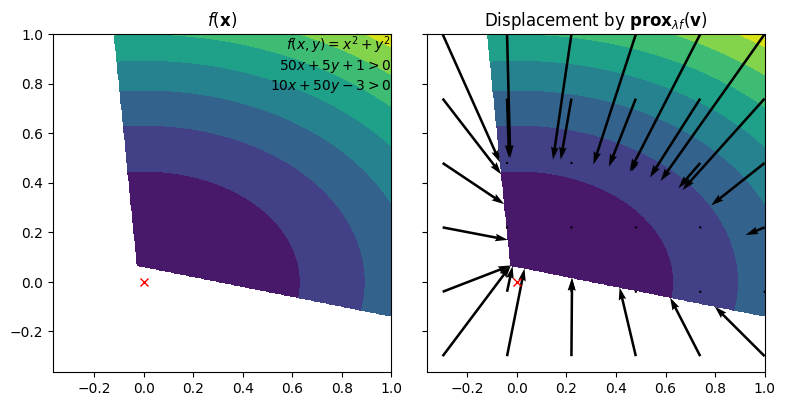

In [6]:
u = y[:, 0].reshape(x_e.shape) - x_e
v = y[:, 1].reshape(x_e.shape) - y_e

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 4))
# Original function
ax1.contourf(x_g, y_g, f(np.c_[x_g.ravel(), y_g.ravel()]).reshape(x_g.shape))
ax1.plot(0, 0, "rx")
ax1.text(1, 1, "$f(x, y) = x^2 + y^2$\n$50x + 5y + 1 > 0$\n$10x + 50y - 3 > 0$", ha="right", va="top")
ax1.set_aspect("equal", "box")
ax1.set_title("$f(\mathbf{x})$")

ax2.contourf(x_g, y_g, f(x).reshape(x_g.shape))
ax2.quiver(x_e, y_e, u, v, angles="xy", scale_units="xy", scale=1)
ax2.plot(0, 0, "rx")
ax2.set_aspect("equal", "box")
ax2.set_title("Displacement by $\mathrm{\mathbf{prox}}_{\lambda f}(\mathbf{v})$")
fig.tight_layout()
# fig.savefig("compressed_sensing_prox.png")

## BP with ADMM

In the basis pursuit problem, $f(\mathbf{x})$ corresponds to $\mathbf{y} - \mathsf{A} \mathbf{x}$ and $g(\mathbf{x})$ corresponds to $\lVert \mathbf{x} \rVert _1$. The proximal operators for these can be written in closed forms:

$$
\begin{align}
\mathrm{\mathbf{prox}}_{\lambda f}(\mathbf{v}) &= \mathsf{A}^\mathrm{T} (\mathsf{A}\mathsf{A}^\mathrm{T})^{-1} \mathbf{y} + \left( \mathsf{I} - \mathsf{A}^\mathrm{T} (\mathsf{A}\mathsf{A}^\mathrm{T})^{-1} \mathsf{A} \right) \mathbf{v} \\
\mathrm{\mathbf{prox}}_{\lambda g}(\mathbf{v}) &= S_\lambda (\mathbf{v})
\end{align}
$$

Here, $S_\lambda (\mathbf{v})$ is the (elementwise) soft thresholding function:

$$
S_\lambda(v_i) = e^{\mathrm{j} \arg v_i} \left( |v_i| - \lambda \right)_+ \quad i = 1, 2, \cdots
$$

where $(\cdot)_+ := \max(\cdot, 0)$ compares the input and zero yielding the larger one.

In [7]:
import numpy as np


def soft_threshold(x, lambda_):
    """Soft threshold function from MATLAB.
    """
    a = np.fmax(np.abs(x) - lambda_, 0)
    return a / (a + lambda_) * x

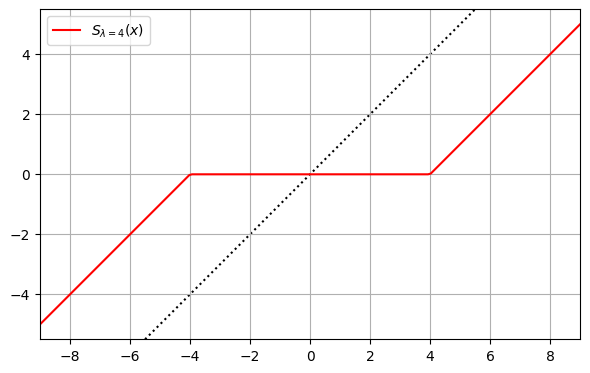

In [9]:
x = np.linspace(-9, 9, 200)
y = soft_threshold(x, 4)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(x, y, "r-", label="$S_{\lambda = 4}(x)$")
ax.axline((0, 0), slope=1, color="k", ls=":", zorder=-1)
# ax.axvline(4, color="k", ls=":", zorder=-1)
# ax.axvline(-4, color="k", ls=":", zorder=-1)
ax.set_aspect("equal", "box")
ax.set_xlim(min(x), max(x))
ax.legend()
ax.grid()
fig.tight_layout()
# fig.savefig("soft_threshold_real.png")

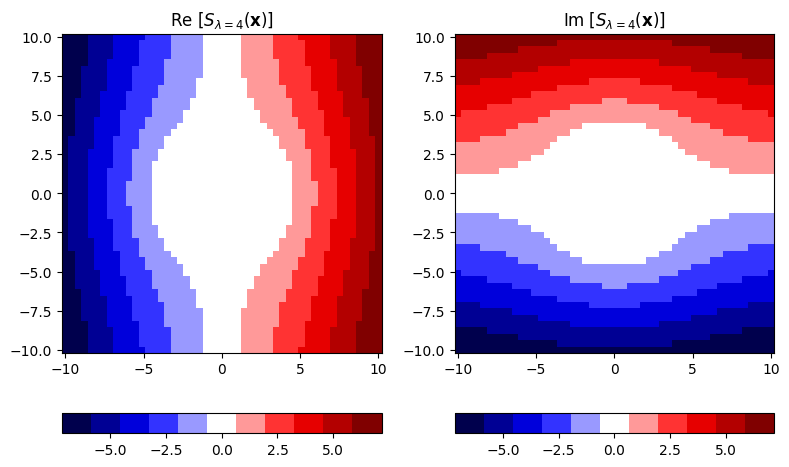

In [10]:
from matplotlib.colorbar import Colorbar


x = np.linspace(-10, 10)[:, None] + 1j * np.linspace(-10, 10)[None, :]
cmap = plt.get_cmap("seismic", lut=11)
values = soft_threshold(x, 4)

fig, ((ax_re, ax_im), (cax_re, cax_im)) = plt.subplots(2, 2, gridspec_kw=dict(height_ratios=(20, 1)), subplot_kw=dict(sharex="row", sharey="row"), figsize=(8, 5))
m_re = ax_re.pcolormesh(x.real, x.imag, values.real, cmap=cmap)
ax_re.set_aspect("equal", "box")
ax_re.set_title("$\mathrm{Re}\ [ S_{\lambda = 4}(\mathbf{x})]$")
Colorbar(ax=cax_re, mappable=m_re, orientation="horizontal")
m_im = ax_im.pcolormesh(x.real, x.imag, values.imag, cmap=cmap)
Colorbar(ax=cax_im, mappable=m_im, orientation="horizontal")
ax_im.set_aspect("equal", "box")
ax_im.set_title("$\mathrm{Im}\ [ S_{\lambda = 4}(\mathbf{x})]$")
fig.tight_layout()
# fig.savefig("soft_threshold_complex.png")